In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
import kds


In [2]:
df = pd.read_csv("Preprocessed.csv")

In [3]:
df.head()
asd = pd.DataFrame(df['AcceptedCmp6'].value_counts()).reset_index()
asd['percentage'] = (asd['count']/asd['count'].sum())*100
asd

,AcceptedCmp6,count,percentage
0,0,1734,84.792176
1,1,311,15.207824


### Our Baseline Accuracy should be above 84.79%
But we define our own profit function


In [4]:
X = df.drop(columns="AcceptedCmp6")
y = df["AcceptedCmp6"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Defining Custom Profit Function

In [5]:
sale_revenue = 11
call_cost = 3
false_positive_cost = call_cost

def calculate_profit(y_true, y_pred):
    tn, fp, fn, tp= confusion_matrix(y_true, y_pred).ravel() #tn, fp, fn, tp
    profit_from_sales = tp * (sale_revenue - call_cost)
    loss_from_wasted_calls = fp * false_positive_cost
    total_profit = profit_from_sales - loss_from_wasted_calls
    return total_profit

def profit_scorer(y_true, y_pred):
    return calculate_profit(y_true, y_pred)

scorer = make_scorer(profit_scorer, greater_is_better=True)




## Functions for finding the best thresholds

In [6]:
def evaluate_thresholds(model, X, y_true, thresholds, sale_revenue, call_cost):
    """
    Evaluate different thresholds to find the one that maximizes profit.

    Parameters:
    - model: Trained model that predicts probabilities (with a `predict_proba` method).
    - X: Feature matrix for evaluation.
    - y_true: True labels (0 or 1).
    - thresholds: List or array of thresholds to evaluate.
    - sale_revenue: Revenue from a successful sale.
    - call_cost: Cost of making a call.

    Returns:
    - best_threshold: The threshold that yields the highest profit.
    - profits: Dictionary with thresholds as keys and corresponding profits as values.
    """
    profits = {}
    for threshold in thresholds:
        # Get predicted probabilities and convert them to class predictions based on the threshold
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        # Calculate profit for this threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        profit_from_sales = tp * (sale_revenue - call_cost)
        loss_from_wasted_calls = fp * call_cost
        total_profit = profit_from_sales - loss_from_wasted_calls
        profits[threshold] = total_profit

    # Find the best threshold
    best_threshold = max(profits, key=profits.get)

    return best_threshold, profits


## Setting up GridSearchCV

In [7]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6,7],
    'criterion': ['entropy'],      
    'max_features': ['log2'],     
    'bootstrap': [True, False]              
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring= scorer)
grid_search.fit(X_train,y_train )


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'bootstrap': [True, False], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'max_features': ['log2'],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [8]:
best_model = grid_search.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
profit_scorer(y_test,y_pred)



np.int64(344)

# Finding the best threshold for maximizing profit

In [9]:
thresholds = np.arange(0.0, 1.01, 0.05)
best_threshold, profits = evaluate_thresholds(
    model=best_model,
    X=X_test,
    y_true=y_test,
    thresholds=thresholds,
    sale_revenue=11,
    call_cost=3
)


In [10]:
print(f"Best threshold: {best_threshold}")
print(f"Profits by threshold: {profits}")

Best threshold: 0.5
Profits by threshold: {np.float64(0.0): np.int64(-623), np.float64(0.05): np.int64(-596), np.float64(0.1): np.int64(-479), np.float64(0.15000000000000002): np.int64(-385), np.float64(0.2): np.int64(-262), np.float64(0.25): np.int64(-111), np.float64(0.30000000000000004): np.int64(40), np.float64(0.35000000000000003): np.int64(157), np.float64(0.4): np.int64(236), np.float64(0.45): np.int64(315), np.float64(0.5): np.int64(344), np.float64(0.55): np.int64(328), np.float64(0.6000000000000001): np.int64(299), np.float64(0.65): np.int64(227), np.float64(0.7000000000000001): np.int64(162), np.float64(0.75): np.int64(111), np.float64(0.8): np.int64(58), np.float64(0.8500000000000001): np.int64(24), np.float64(0.9): np.int64(8), np.float64(0.9500000000000001): np.int64(0), np.float64(1.0): np.int64(0)}


# Cummulative Gains

In [11]:
def cumulative_gains_chart(y_true, y_prob):
    """
    Plots a cumulative gains chart.

    Parameters:
    - y_true: Array-like of shape (n_samples,) with true binary labels (0 or 1).
    - y_prob: Array-like of shape (n_samples,) with predicted probabilities for the positive class.

    Returns:
    - None: Displays the cumulative gains chart.
    """
    # Create a DataFrame with true labels and predicted probabilities
    data = pd.DataFrame({'true': y_true, 'prob': y_prob})
    # Sort by predicted probability in descending order
    data = data.sort_values(by='prob', ascending=False).reset_index(drop=True)

    # Calculate cumulative positive count
    data['cumulative_true'] = data['true'].cumsum()
    # Calculate total number of positives
    total_positives = data['true'].sum()
    # Calculate cumulative gains as a percentage
    data['cumulative_gain'] = data['cumulative_true'] / total_positives

    # Calculate population percentages
    data['population_percentage'] = np.arange(1, len(data) + 1) / len(data)

    # Plot the cumulative gains chart
    plt.figure(figsize=(10, 6))
    plt.plot(data['population_percentage'], data['cumulative_gain'], label='Cumulative Gains', color='blue')
    plt.plot([0, 1], [0, 1], label='Baseline (Random)', linestyle='--', color='red')  # Random model
    plt.title('Cumulative Gains Chart')
    plt.xlabel('Proportion of Population Contacted')
    plt.ylabel('Cumulative Gain (Proportion of True Positives)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

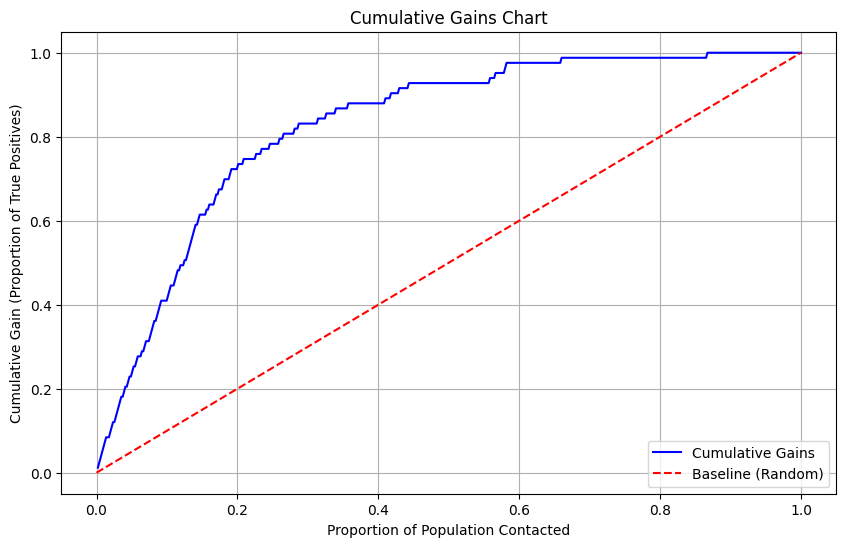

In [12]:
y_prob = best_model.predict_proba(X_test)[:, 1]
cumulative_gains_chart(y_test, y_prob)

### Conclusions

Here we can see, that by calling only 40% of our customers we can identify almost 90% of our potential buyers. 

### Trying cummulative gains differently

Text(0, 0.5, 'Cumulative Gain (Proportion of True Positives)')

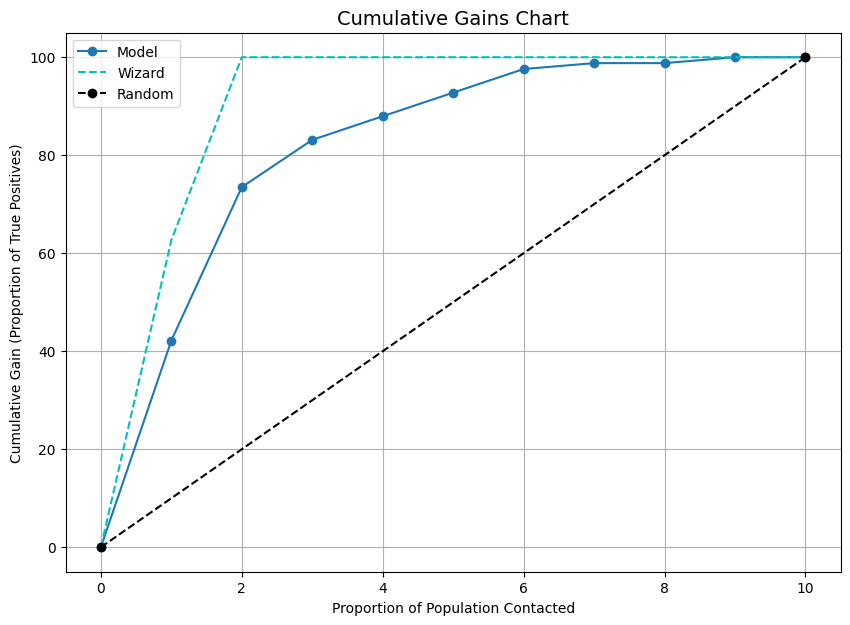

In [37]:
rf_probs =  best_model.predict_proba(X_test)
plt.figure(figsize=(10,7))
kds.metrics.plot_cumulative_gain(y_test, rf_probs[:,1], title="Cumulative Gains Chart")
plt.xlabel('Proportion of Population Contacted')
plt.ylabel('Cumulative Gain (Proportion of True Positives)')

## Lift Curve

Purpose: A lift chart shows how much better the model performs compared to random guessing (or a baseline model).  
Calculation: The lift is calculated as the ratio of the model's performance over random guessing.  
>Lift at a particular point = Gain at that point / Random model (random selection) gain at that point   


X-axis: Proportion of data (typically, this is the percentage of the total data that you have ranked by predicted probability, e.g., top 10% of predictions).  
Y-axis: Lift, which shows how much better the model is compared to random chance.


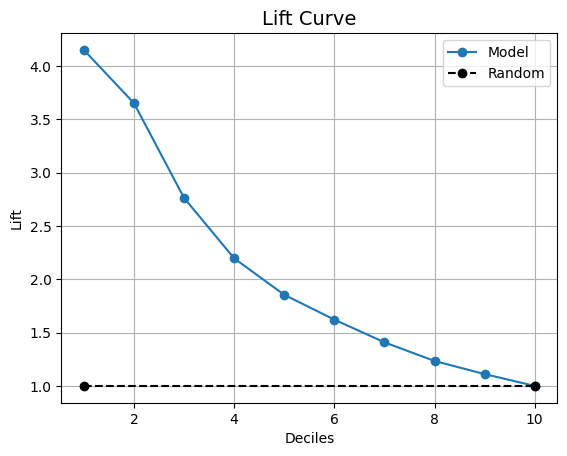

In [ ]:
plt.figure()
kds.metrics.plot_lift(y_test, rf_probs[:,1], title="Lift Curve")


## ROC curve

The curve highlights the cost of increasing sensitivity (e.g., catching more true positives) at the expense of specificity (e.g., generating more false positives).

x axis: False Positive rate: Out of the negative instances, how many of them are falsely identified as positives    
y axis: True Positive Rate: Precentage of positive instances identified out of all the positive instances  

#### AUC - Area Under The Curve  
Defines how well the model can distinguish between positive and negative classes.  
>AUC = 1 -> Perfect disrimination  
>AUC = 0.5 -> Model is no better than random guessing

PS: ROC curves can be a good tool when comparing the performance of multiple models

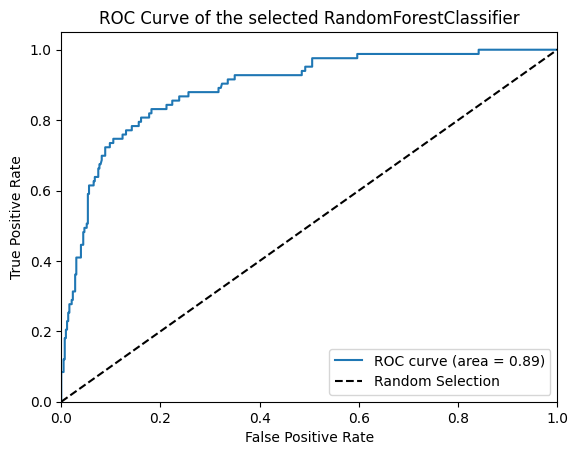

In [33]:
fpr, tpr, thresholds_roc = roc_curve(y_test, rf_probs[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

plt.figure()
plt.plot(fpr,tpr, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'k--', label='Random Selection')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the selected RandomForestClassifier')
plt.legend()
plt.show()